## Import Packges

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, DepthwiseConv2D
from keras.layers import BatchNormalization, LayerNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model, load_model
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta, SGD
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
import time
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100
import sys

!pip install mat73
import mat73
!pip install tensorflow_addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

topic = 'Ming/'
work_dir = '/content/gdrive/My Drive/Colab Notebooks/' + topic
import os
os.chdir(work_dir)
!pwd
save_path = work_dir

model_dir = save_path+"/DCGAN_model"
fig_path = work_dir + 'head_to_latent_fig/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/Ming


## Define DC-GAN

In [ ]:
class ConvGAN():
  def __init__(self):
    self.img_rows = 128
    self.img_cols = 128
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.latent_dim = 16
    print(self.img_shape)
    optimizer = Adam(1e-4, 0.5)

    self.discriminator = None
    self.generator = None


In [ ]:
conv_gan = ConvGAN()
conv_gan.discriminator = tf.keras.models.load_model(model_dir+'/DCGAN_discriminator_TI_4')
conv_gan.generator = tf.keras.models.load_model(model_dir+'/DCGAN_generator_TI_4')

(128, 128, 1)


## Load Data

In [ ]:
################### transient heads ####################
field_type = 'Channel'
pumping_type = 'transient'

data = mat73.loadmat('./Data/0719/'+field_type+'_transient_monitored_0719.mat')

In [ ]:
print(data.keys())
pump_well_id = data['pump_well_id'].astype(int)-1
print(pump_well_id)

y_save = data['y_save_monitored']

print(y_save.shape)

fields = data['fields'].T
# fields = np.reshape(fields,(fields.shape[0],128,128))
# fields = np.transpose(fields, (0,2,1)).reshape((fields.shape[0],-1))

print(fields.shape)
alpha = data['rv'].T
print(alpha.shape)
Y_raw = y_save
Y = np.zeros(y_save.shape)
Y = np.delete(Y,0,axis=1)
print(Y.shape)

for ii in range(Y.shape[-1]):
  # print(pump_well_id[ii])
  # print(np.argmin(Y_raw[3,:,8,ii]))

  Y[:,:,:,ii] = np.delete(Y_raw[:,:,:,ii],pump_well_id[ii],axis=1)
  # print(np.sort(Y_raw[3,:,8,ii])[:2])
  # print(np.min(Y[3,:,8,ii]))

select_time_steps = np.arange(2,11,2)
print(select_time_steps)
Y = Y[:,:,select_time_steps,:]
NR = Y.shape[0]
Y = Y.reshape([NR,-1])
print(Y.shape)
# ########################################################


train_test_cut = int(0.9*alpha.shape[0])
X_train, X_test = alpha[:train_test_cut], alpha[train_test_cut:]
Y_train, Y_test = Y[:train_test_cut], Y[train_test_cut:]

print(X_train.shape, Y_train.shape)

dict_keys(['fields', 'pump_well_id', 'rv', 'y_save_monitored'])
[ 0  4 12 20 24]
(5000, 25, 11, 5)
(5000, 16384)
(5000, 16)
(5000, 24, 11, 5)
[ 2  4  6  8 10]
(5000, 600)
(4500, 16) (4500, 600)


# DC-GAN Decoding & Smoothing


In [ ]:
############### define domain with (0,0) at center ######
Lox, Loy = 1, 1
nx, ny = 128, 128
dx, dy = Lox/nx, Loy/ny
x = np.arange((-Lox/2+dx/2),(Lox/2),dx)
y = np.arange((-Lox/2+dx/2),(Lox/2),dy)
# Domain bounds   
lbs = np.array([min(x),min(y)])
ubs = np.array([max(x),max(y)])

Xm, Ym = np.meshgrid(x,y)

0.0


Text(0.5, 1.0, 'Generated from GAN')

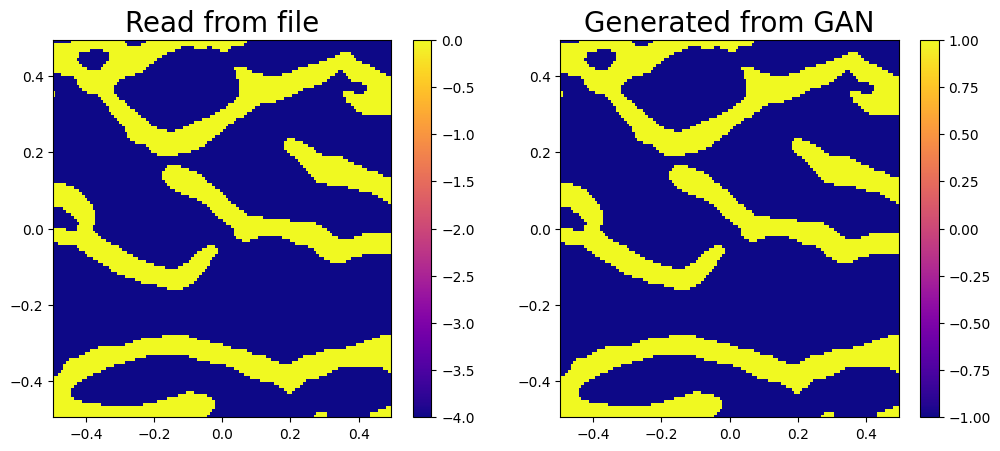

In [ ]:
fid = 10

gen_imgs = conv_gan.generator.predict(X_test)

for i in range(1):
  median_filtered_img = tfa.image.median_filter2d(gen_imgs,(5,5))

# Split image value
true_imgs  = median_filtered_img[:,:,:,0].numpy()
split_val = 0.0 #np.mean(rescaled_img)
print(split_val)

true_imgs[true_imgs > split_val]=1.0
true_imgs[true_imgs <=split_val]=-1.0

fig, axs = plt.subplots(1,2,figsize=(12,5))
ax = axs[0]
im = ax.pcolormesh(Xm,Ym,np.reshape(fields[fid+train_test_cut], (nx,ny), order='F'), cmap='plasma')
fig.colorbar(im, ax=ax)
ax.set_title('Read from file',fontsize=20)

ax = axs[1]
im = ax.pcolormesh(Xm,Ym,true_imgs[fid,:,:], cmap='plasma')
fig.colorbar(im, ax=ax)
ax.set_title('Generated from GAN',fontsize=20)


# Define NN

In [ ]:
hidden_act = None
hidden_dim = 3000
input = Input(shape = (Y_train.shape[-1],))
# g = LayerNormalization(axis=1)(input)
g = BatchNormalization()(input)

g = Dense(hidden_dim)(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0.2)(g)

g = Dense(hidden_dim)(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0.2)(g)

g = Dense(hidden_dim)(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0.2)(g)

g = Dense(hidden_dim)(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0.2)(g)

g_out = Dense(16)(g)
# g_out = LayerNormalization(axis=1)(g_out)

G = Model(input, g_out, name = field_type+'_'+pumping_type)
G.summary()


alpha_loss_weight = np.ones((16,))

alpha_loss_weight /= np.linalg.norm(alpha_loss_weight)

def weighted_mse(weights=alpha_loss_weight):
  def loss(y_true, y_pred):
    squared_difference_1 = tf.square(y_true - y_pred)*weights
    total_loss = tf.reduce_mean(squared_difference_1, axis=-1)
    return total_loss
  return loss


step = tf.Variable(0, trainable=False)
boundaries = [10000, 20000]
values = [1e-3, 1e-4, 1e-5]
learning_rate_fn = PiecewiseConstantDecay(
    boundaries, values)

# Later, whenever we perform an optimization step, we pass in the step.
learning_rate = learning_rate_fn(step)
# learning_rate = 0.0005
print(learning_rate)
G.compile(loss=weighted_mse(), optimizer=Adam(learning_rate, beta_1=0.5))

Model: "Channel_transient"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 600)]             0         
                                                                 
 batch_normalization_10 (Bat  (None, 600)              2400      
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            (None, 3000)              1803000   
                                                                 
 batch_normalization_11 (Bat  (None, 3000)             12000     
 chNormalization)                                                
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 3000)              0         
                                                                 
 dense_11 (Dense)            (None, 3000)        

# Train Model

In [ ]:
batch_size = 1000

epochs = 50000
print_interval = 1000
for epoch in range(epochs):
  idx = np.random.randint(0, Y_train.shape[0], batch_size)
  to_train = Y_train[idx]
  expect_output = X_train[idx]
  loss = G.train_on_batch(to_train, expect_output)
  if epoch % print_interval == 0:
      print("[epoch %d], [the loss is %f]" % (epoch, loss))

  # if loss < 0.01:
  #     break

[epoch 0], [the loss is 0.490252]
[epoch 1000], [the loss is 0.010339]
[epoch 2000], [the loss is 0.006465]
[epoch 3000], [the loss is 0.007275]
[epoch 4000], [the loss is 0.003795]
[epoch 5000], [the loss is 0.004463]
[epoch 6000], [the loss is 0.003557]
[epoch 7000], [the loss is 0.002747]
[epoch 8000], [the loss is 0.002539]
[epoch 9000], [the loss is 0.001424]
[epoch 10000], [the loss is 0.001831]
[epoch 11000], [the loss is 0.001680]
[epoch 12000], [the loss is 0.001462]


KeyboardInterrupt: ignored

# Load trained NN

In [ ]:
model_name = './head_to_latent_model/'+field_type+'_'+pumping_type + '_5000_new'
# G = load_model(model_name)

G = load_model(model_name, custom_objects={ 'loss': weighted_mse(alpha_loss_weight) })

G.summary()

Model: "Channel_transient"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 600)]             0         
                                                                 
 batch_normalization_10 (Bat  (None, 600)              2400      
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            (None, 3000)              1803000   
                                                                 
 batch_normalization_11 (Bat  (None, 3000)             12000     
 chNormalization)                                                
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 3000)              0         
                                                                 
 dense_11 (Dense)            (None, 3000)        

# Inverse on test cases

In [ ]:
predictions = G.predict(Y_test)


pred_imgs = conv_gan.generator.predict(predictions)

for i in range(1):
  pred_imgs = tfa.image.median_filter2d(pred_imgs,(5,5))

pred_imgs = pred_imgs[:,:,:,0].numpy()
split_val = 0.0 #np.mean(rescaled_img)

pred_imgs[pred_imgs>split_val]=1.0
pred_imgs[pred_imgs<=split_val]=-1.0


In [ ]:
thres = 0.1
K_len = 1

acc_list = np.zeros((1,Y_test.shape[0]))
for check_id in range(Y_test.shape[0]):

  logK_true = true_imgs[check_id,:,:]
  logK_pred = pred_imgs[check_id,:,:]

  res = abs(logK_true-logK_pred)/K_len
  acc = sum(sum(res<thres))/(nx*ny)

  acc_list[0,check_id] = acc

print("Min Acc: ", np.min(acc_list))
print("Max Acc: ", np.max(acc_list))
print("Arg Max Acc: ", np.argmax(acc_list))
print("Over 90%: ", acc_list[acc_list>=0.9].shape[0])

print("mean Acc: ", np.mean(acc_list))
print("std Acc: ", np.std(acc_list))

Min Acc:  0.7386474609375
Max Acc:  0.93792724609375
Arg Max Acc:  225
Over 90%:  42
mean Acc:  0.855294189453125
std Acc:  0.034756940785728684


# Best Estimate

0.93792724609375


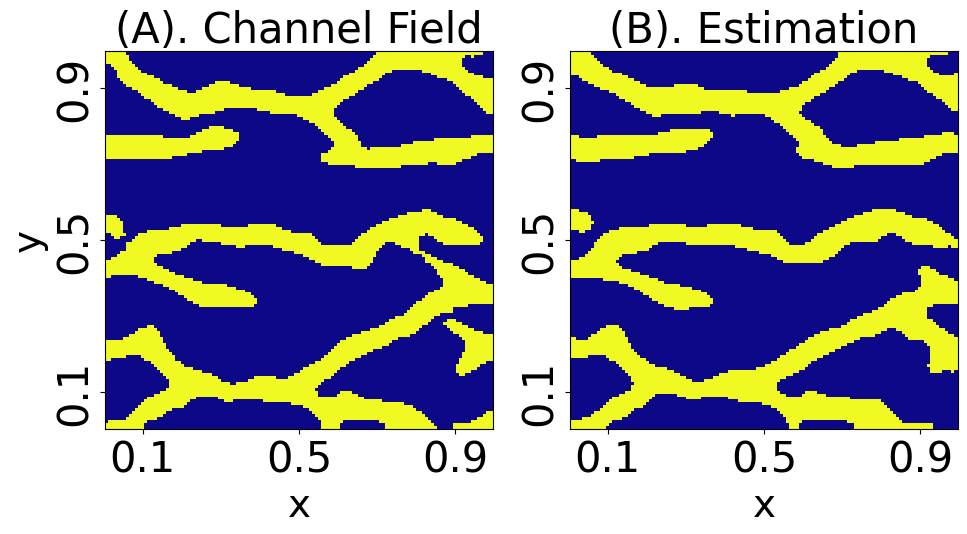

In [ ]:
# check_id = np.argmax(acc_list)
fid = np.argmax(acc_list)

#set font size
axis_label_font_size = 28
axis_tick_font_size = 30
legend_fontszie = 25
colorbar_font_size = 30
title_size = 30

logK_true = true_imgs[fid,:].reshape((nx,ny), order='F')
logK_pred = pred_imgs[fid,:].reshape((nx,ny), order='F')

maxlK, minlK = np.max(logK_true), np.min(logK_true)

fig, axs = plt.subplots(1,2,figsize=(11,5))
ax = axs[0]
im = ax.pcolormesh(Xm,Ym,logK_true, cmap='plasma')
im.set_clim((minlK, maxlK))
ax.set_title('(A). '+field_type+' Field',fontsize=title_size)

ax.set_xlabel('x',fontsize=axis_label_font_size)
ax.set_ylabel('y',fontsize=axis_label_font_size)

# cbar = fig.colorbar(im, ax=ax)
# cbar.ax.tick_params(labelsize=colorbar_font_size)

ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,Fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,Fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

ax = axs[1]
im = ax.pcolormesh(Xm,Ym,logK_pred, cmap='plasma')
# im.set_clim((minlK, maxlK))

ax.set_title('(B). Estimation',fontsize=title_size)

ax.set_xlabel('x',fontsize=axis_label_font_size)
# ax.set_ylabel('y',fontsize=axis_label_font_size)

# cbar = fig.colorbar(im, ax=ax)
# cbar.ax.tick_params(labelsize=colorbar_font_size)

ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,Fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,Fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

# threshold 10%
thres = 0.15
K_len = maxlK - minlK 

acc = abs(logK_true-logK_pred)/K_len

print(sum(sum(acc<thres))/(nx*ny))

fig.savefig(fig_path+field_type+'_'+pumping_type+'_best.png',bbox_inches="tight")


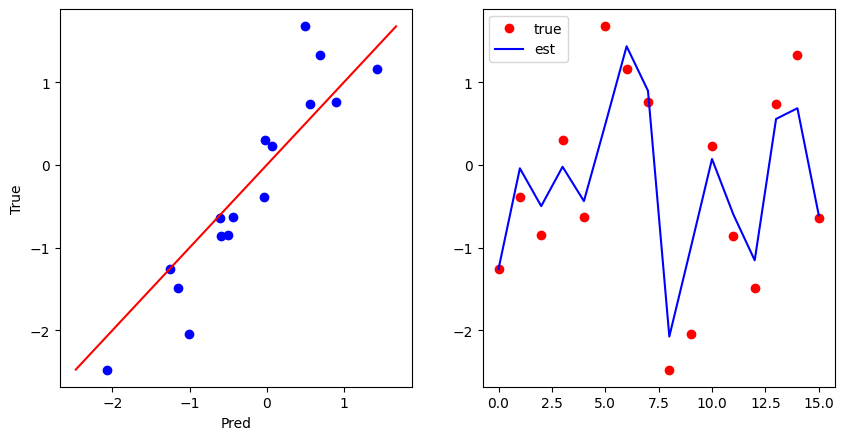

In [ ]:
check_id = fid
fig, axs = plt.subplots(1,2,figsize=(10,5))

ax = axs[0]
plot_max = max(np.max(predictions[check_id]), np.max(X_test[check_id,:]))
plot_min = min(np.min(predictions[check_id]), np.min(X_test[check_id,:]))

ax.plot(predictions[check_id,:15],X_test[check_id,:15],'ob')
ax.plot(predictions[check_id,15:],X_test[check_id,15:],'ob')
ax.plot(np.linspace(plot_min,plot_max,5),np.linspace(plot_min,plot_max,5),'-r')

ax.set_xlabel('Pred')
ax.set_ylabel('True')

ax = axs[1]
xplot = np.arange(predictions.shape[1])
ax.plot(xplot, X_test[check_id,:],'or',label='true')
ax.plot(xplot, predictions[check_id,:],'b',label='est')

ax.legend()

# Wrost Estimate

0.61138916015625


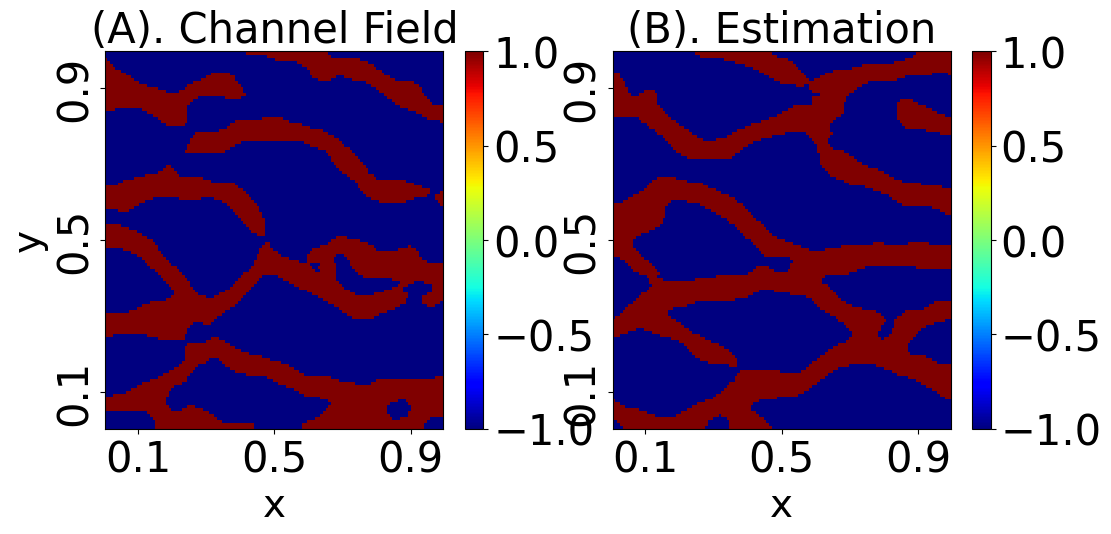

In [ ]:
# check_id = np.argmax(acc_list)
fid = np.argmin(acc_list)

#set font size
axis_label_font_size = 28
axis_tick_font_size = 30
legend_fontszie = 25
colorbar_font_size = 30
title_size = 30

logK_true = true_imgs[fid,:].reshape((nx,ny), order='F')
logK_pred = pred_imgs[fid,:].reshape((nx,ny), order='F')

maxlK, minlK = np.max(logK_true), np.min(logK_true)

fig, axs = plt.subplots(1,2,figsize=(12,5))
ax = axs[0]
im = ax.pcolormesh(Xm,Ym,logK_true, cmap='jet')
im.set_clim((minlK, maxlK))
ax.set_title('(A). '+field_type+' Field',fontsize=title_size)

ax.set_xlabel('x',fontsize=axis_label_font_size)
ax.set_ylabel('y',fontsize=axis_label_font_size)

cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=colorbar_font_size)

ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,Fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,Fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

ax = axs[1]
im = ax.pcolormesh(Xm,Ym,logK_pred, cmap='jet')
# im.set_clim((minlK, maxlK))

ax.set_title('(B). Estimation',fontsize=title_size)

ax.set_xlabel('x',fontsize=axis_label_font_size)
# ax.set_ylabel('y',fontsize=axis_label_font_size)

cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=colorbar_font_size)

ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,Fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,Fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

# threshold 10%
thres = 0.15
K_len = maxlK - minlK 

acc = abs(logK_true-logK_pred)/K_len

print(sum(sum(acc<thres))/(nx*ny))

fig.savefig(fig_path+field_type+'_'+pumping_type+'_wrost.png',bbox_inches="tight")


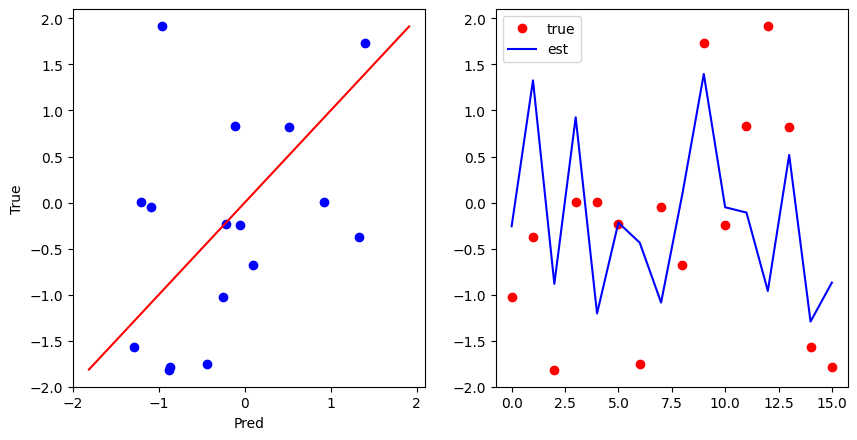

In [ ]:
check_id = fid
fig, axs = plt.subplots(1,2,figsize=(10,5))

ax = axs[0]
plot_max = max(np.max(predictions[check_id]), np.max(X_test[check_id,:]))
plot_min = min(np.min(predictions[check_id]), np.min(X_test[check_id,:]))

ax.plot(predictions[check_id,:15],X_test[check_id,:15],'ob')
ax.plot(predictions[check_id,15:],X_test[check_id,15:],'ob')
ax.plot(np.linspace(plot_min,plot_max,5),np.linspace(plot_min,plot_max,5),'-r')

ax.set_xlabel('Pred')
ax.set_ylabel('True')

ax = axs[1]
xplot = np.arange(predictions.shape[1])
ax.plot(xplot, X_test[check_id,:],'or',label='true')
ax.plot(xplot, predictions[check_id,:],'b',label='est')

ax.legend()

# Uncertainty Quantification

In [ ]:
fid = np.argmax(acc_list)
n_noises = 20
# print(Y_test.shape)
# print(Y_test[fid].shape)
Noised_Y_test = Y_test[fid] + np.random.normal(0,np.abs(Y_test[fid]*0.05),[n_noises,Y_test[fid].shape[0]])
# print(Y_test[fid,0:5])

# print(Noised_Y_test[0:2,0:5])
predictions = G.predict(Noised_Y_test)

# print(predictions.shape)

pred_imgs = conv_gan.generator.predict(predictions)

for i in range(1):
  pred_imgs = tfa.image.median_filter2d(pred_imgs,(5,5))

pred_imgs = pred_imgs[:,:,:,0].numpy()

split_val = 0.0 #np.mean(rescaled_img)

pred_imgs[pred_imgs>split_val]=1.0
pred_imgs[pred_imgs<=split_val]=-1.0

logK_true = true_imgs[fid]

acc_list = np.zeros((n_noises,))
thres = 0.15

for check_id in range(n_noises):

  logK_pred = pred_imgs[check_id,:].reshape((nx,ny), order='F')
  K_len = np.max(logK_true) - np.min(logK_true)

  res = abs(logK_true-logK_pred)/K_len
  acc = sum(sum(res<thres))/(nx*ny)

  acc_list[check_id] = acc

print("Min Acc: ", np.min(acc_list))
print("Max Acc: ", np.max(acc_list))
print("Arg Max Acc: ", np.argmax(acc_list))
print("Over 90%: ", acc_list[acc_list>=0.9].shape[0])

print("mean Acc: ", np.mean(acc_list))
print("std Acc: ", np.std(acc_list))



Min Acc:  0.9013671875
Max Acc:  0.929931640625
Arg Max Acc:  5
Over 90%:  20
mean Acc:  0.9139312744140625
std Acc:  0.00831264937686075


[12 19  4 16 13 15  3 17 11  5]


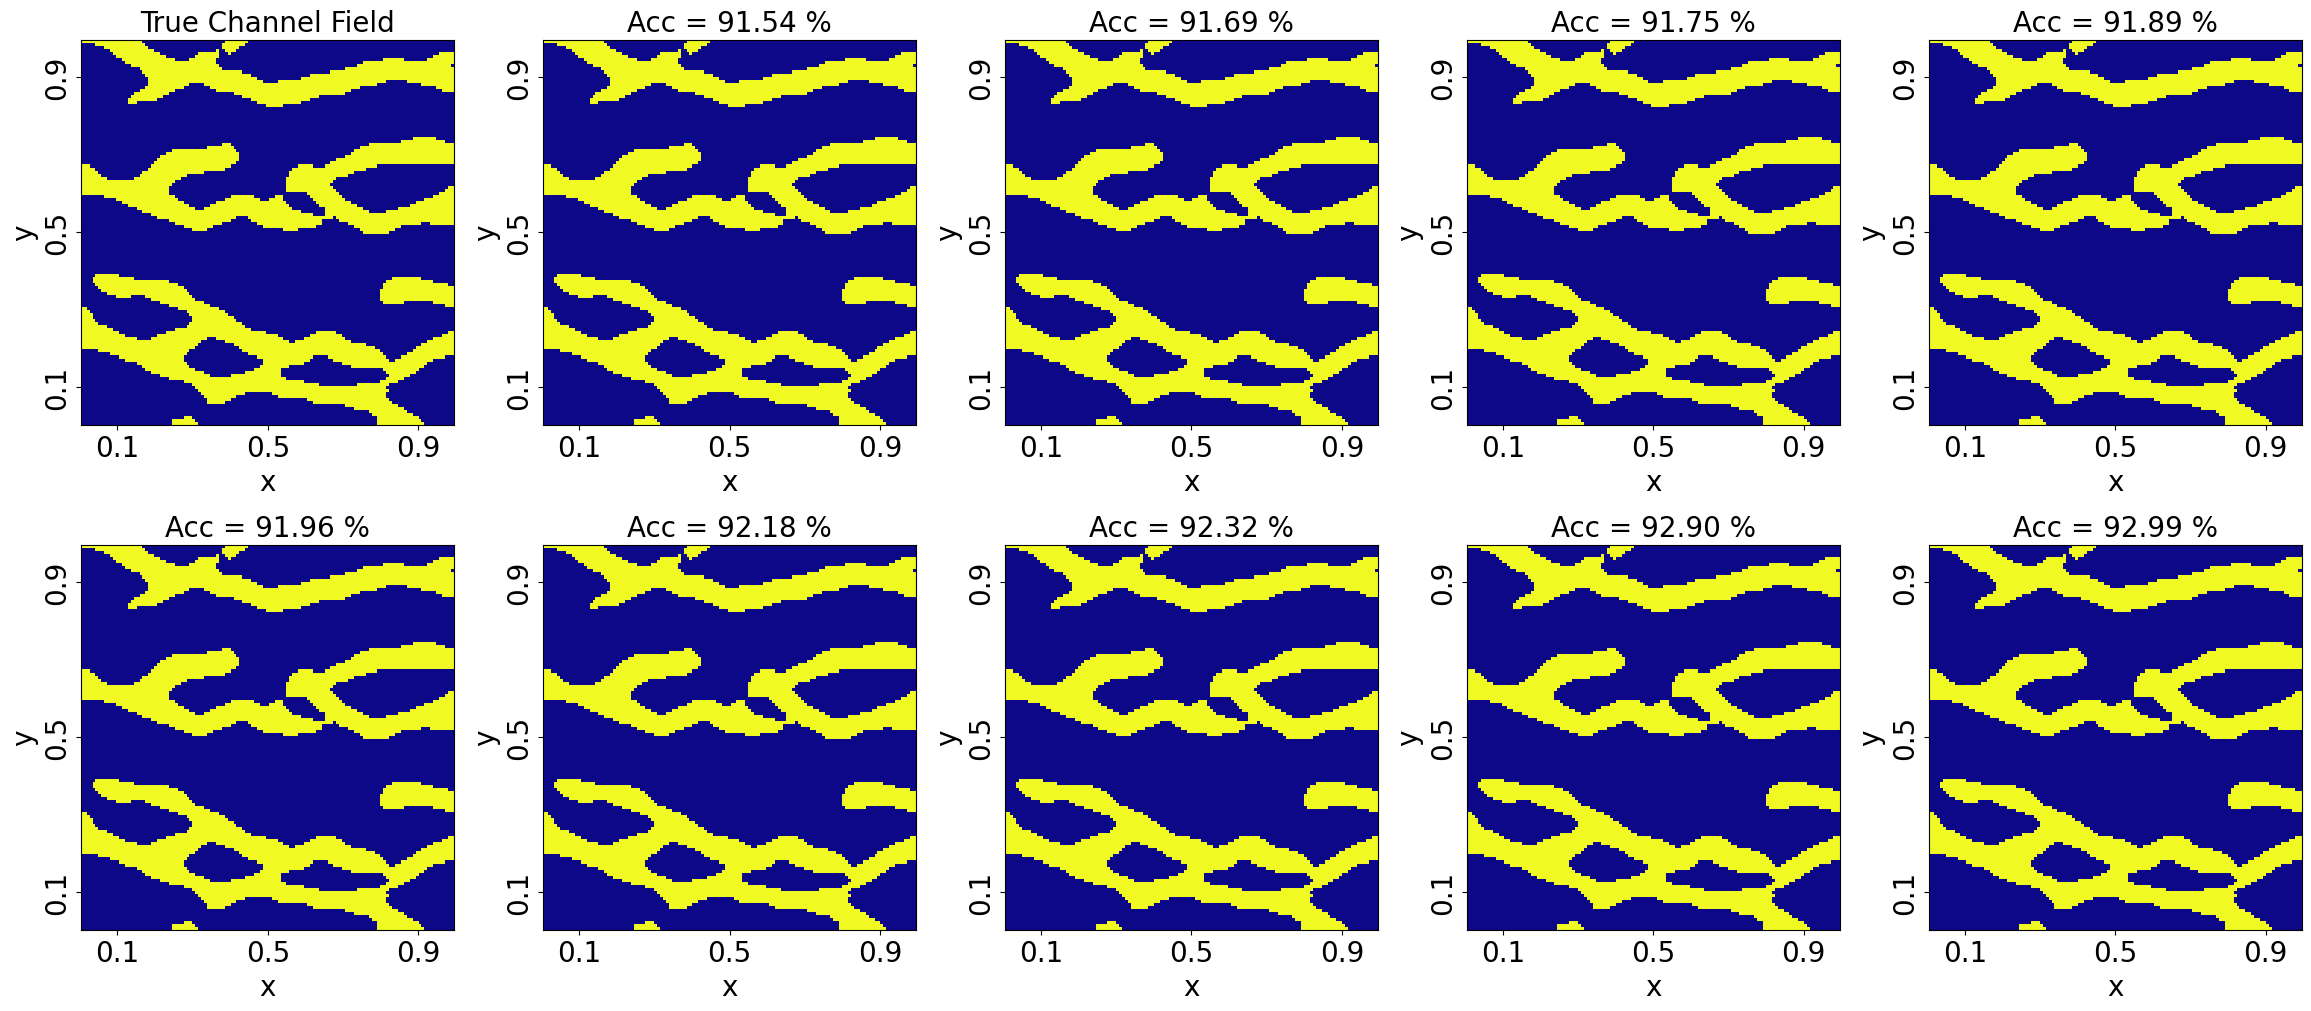

In [ ]:
#set font size
from mpl_toolkits.axes_grid1 import make_axes_locatable

axis_label_font_size = 20
axis_tick_font_size = 20
legend_fontszie = 20
colorbar_font_size = 20
title_size = 20

plot_id_list = np.argsort(acc_list)[-10:]

print(plot_id_list)
fig, axs = plt.subplots(2, 5, figsize=(23,10),constrained_layout=True) 
axs = axs.flatten()

for i in range(axs.shape[0]):
  ax = axs[i]
  logK_pred = pred_imgs[plot_id_list[i],:].reshape((nx,ny), order='F')

  if i == 0:
    im = ax.pcolormesh(Xm,Ym,logK_true, cmap='plasma')
    ax.set_title('True '+field_type+' Field',fontsize=title_size)

  else:
    im = ax.pcolormesh(Xm,Ym,logK_true, cmap='plasma')
    acc = acc_list[plot_id_list[i]]*100
    ax_name = "Acc = %.2f %%" % acc
    ax.set_title(ax_name, fontsize=title_size)

  im.set_clim((minlK, maxlK))

  ax.set_xlabel('x',fontsize=axis_label_font_size)
  ax.set_ylabel('y',fontsize=axis_label_font_size)
# You can do this easily with a matplotlib AxisDivider.

# The example from the linked page also works without using subplots:

# import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# import numpy as np
    
# plt.figure()
# ax = plt.gca()
# im = ax.imshow(np.arange(100).reshape((10,10)))
    
  # create an axes on the right side of ax. The width of cax will be 5%
  # of ax and the padding between cax and ax will be fixed at 0.05 inch.
  # divider = make_axes_locatable(ax)
  # cax = divider.append_axes("right", size="10%", pad=0.05)
  # cbar = fig.colorbar(im, cax=cax)

  # cbar = fig.colorbar(im, ax=ax, fraction=0.005, shrink=1.0)
  # cbar.ax.tick_params(labelsize=colorbar_font_size)

  ticks = [-0.4, 0.0, 0.4]

  labels = [0.1, 0.5, 0.9]
  ax.set_xticks(ticks)
  ax.set_yticks(ticks)
  ax.set_xticklabels(labels,Fontsize=axis_tick_font_size,ha='center')
  ax.set_yticklabels(labels,Fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

# Save Model

In [ ]:
# G.save('./head_to_latent_model/'+field_type+'_'+pumping_type+'_5000')